In [ ]:
# Cell 1: Setup & Imports
!pip install pillow pandas scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# New imports for structural and perceptual metrics
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Cell 2: Image helpers (load, preprocess, show)

imsize = 512 if torch.cuda.is_available() else 256  # adjust for Colab GPU/CPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

unloader = transforms.ToPILImage()

# ImageNet normalization (for VGG)
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

def load_image(path):
    image = Image.open(path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def image_from_url(url, save_path="temp_image.jpg"):
    import requests
    from io import BytesIO
    r = requests.get(url)
    img = Image.open(BytesIO(r.content)).convert("RGB")
    img.save(save_path)
    return load_image(save_path)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
# Cell 3: VGG feature extractor and Gram matrix

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


def gram_matrix(input_tensor):
    b, ch, h, w = input_tensor.size()
    features = input_tensor.view(b * ch, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * ch * h * w)


# Choose VGG19 backbone
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Define layer mapping as in standard VGG (conv names)
vgg_layer_map = {
    '0': 'conv1_1',
    '2': 'conv1_2',
    '5': 'conv2_1',
    '7': 'conv2_2',
    '10': 'conv3_1',
    '12': 'conv3_2',
    '14': 'conv3_3',
    '16': 'conv3_4',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '23': 'conv4_3',
    '25': 'conv4_4',
    '28': 'conv5_1',
    '30': 'conv5_2',
    '32': 'conv5_3',
    '34': 'conv5_4',
}


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 84.1MB/s]


In [ ]:
# Cell 4: Layer configuration

# Default style layers (you will analyze them!)
default_style_layers = [
    'conv1_1',
    'conv2_1',
    'conv3_1',
    'conv4_1',
    'conv5_1'
]

# Default content layer
default_content_layers = [
    'conv4_2'
]


In [ ]:
# Cell 5: Feature extraction and per-layer loss computation

def extract_features(x, model, layers_to_return=None):
    """
    Pass x through VGG and return features in a dict: {layer_name: activation}
    """
    features = {}
    current = x
    for name, layer in model._modules.items():
        current = layer(current)
        layer_name = vgg_layer_map.get(name, None)
        if layer_name and (layers_to_return is None or layer_name in layers_to_return):
            features[layer_name] = current
    return features


def compute_style_content_losses(
    gen_feats, style_feats, content_feats,
    style_layers, content_layers,
    style_weights=None
):
    """
    Returns:
      style_loss_total, content_loss_total, style_loss_dict, content_loss_dict
    """
    if style_weights is None:
        style_weights = {l: 1.0 for l in style_layers}

    style_loss_dict = {}
    content_loss_dict = {}

    # Style loss per layer
    style_loss_total = 0.0
    for l in style_layers:
        G = gram_matrix(gen_feats[l])
        A = gram_matrix(style_feats[l])
        loss_l = torch.nn.functional.mse_loss(G, A)
        loss_l_weighted = style_weights[l] * loss_l
        style_loss_dict[l] = loss_l.detach().item()
        style_loss_total += loss_l_weighted

    # Content loss
    content_loss_total = 0.0
    for l in content_layers:
        Fg = gen_feats[l]
        Fc = content_feats[l]
        loss_l = torch.nn.functional.mse_loss(Fg, Fc)
        content_loss_dict[l] = loss_l.detach().item()
        content_loss_total += loss_l

    return style_loss_total, content_loss_total, style_loss_dict, content_loss_dict


In [ ]:
# Cell 6: Core style transfer function with logging

def run_style_transfer(
    content_img,
    style_img,
    num_steps=300,
    style_weight=1e6,
    content_weight=1,
    style_layers=None,
    content_layers=None,
    log_prefix="exp1"
):
    if style_layers is None:
        style_layers = default_style_layers
    if content_layers is None:
        content_layers = default_content_layers

    # Normalize wrapper
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Precompute style & content features
    content_norm = normalization(content_img)
    style_norm = normalization(style_img)

    with torch.no_grad():
        content_feats = extract_features(content_norm, vgg, layers_to_return=set(style_layers + content_layers))
        style_feats = extract_features(style_norm, vgg, layers_to_return=set(style_layers + content_layers))

    # Initialize generated image as content clone
    input_img = content_img.clone().requires_grad_(True).to(device)

    optimizer = optim.LBFGS([input_img])

    log_data = []

    run = [0]
    while run[0] <= num_steps:

        def closure():
            optimizer.zero_grad()
            gen_norm = normalization(input_img)

            gen_feats = extract_features(gen_norm, vgg, layers_to_return=set(style_layers + content_layers))

            style_loss, content_loss, style_loss_dict, content_loss_dict = compute_style_content_losses(
                gen_feats, style_feats, content_feats, style_layers, content_layers
            )

            total_loss = style_weight * style_loss + content_weight * content_loss
            total_loss.backward()

            # Logging
            iter_data = {
                "iter": run[0],
                "total_loss": total_loss.detach().item(),
                "style_loss_total": style_loss.detach().item(),
                "content_loss_total": content_loss.detach().item(),
            }
            for l, v in style_loss_dict.items():
                iter_data[f"style_{l}"] = v
            for l, v in content_loss_dict.items():
                iter_data[f"content_{l}"] = v
            log_data.append(iter_data)

            if run[0] % 50 == 0:
                print(f"[{log_prefix}] Iter {run[0]} | Total: {total_loss.item():.4f} | "
                      f"Style: {style_loss.item():.4f} | Content: {content_loss.item():.4f}")

            run[0] += 1
            return total_loss

        optimizer.step(closure)

    # Detach final image
    with torch.no_grad():
        final_img = input_img.clamp(0, 1).detach()

    # Convert logs to DataFrame
    log_df = pd.DataFrame(log_data)

    return final_img, log_df


Content image:


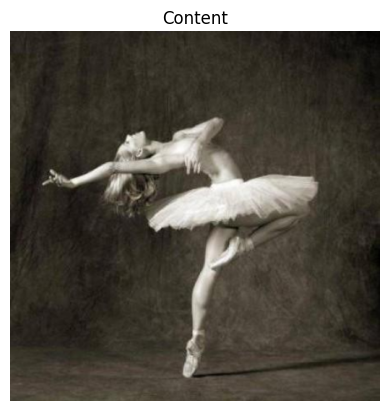

Style image:


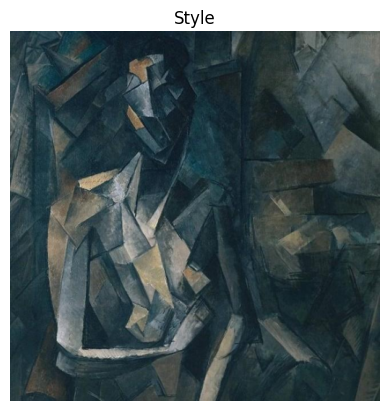

[baseline] Iter 0 | Total: 13.6073 | Style: 0.0000 | Content: 0.0000
[baseline] Iter 50 | Total: 0.9757 | Style: 0.0000 | Content: 0.5129
[baseline] Iter 100 | Total: 0.6916 | Style: 0.0000 | Content: 0.4087
[baseline] Iter 150 | Total: 0.6360 | Style: 0.0000 | Content: 0.3792
Final stylized image:


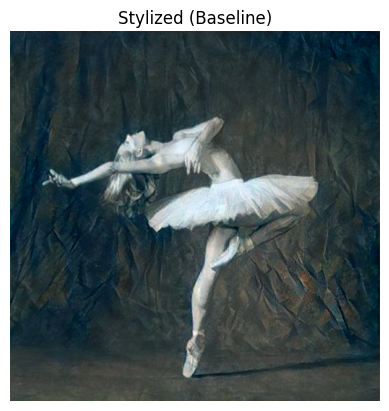

,iter,total_loss,style_loss_total,content_loss_total,style_conv1_1,style_conv2_1,style_conv3_1,style_conv4_1,style_conv5_1,content_conv4_2
0,0,13.607347,0.000014,0.000000e+00,0.000002,0.000004,0.000006,1.803848e-06,1.806575e-07,0.000000e+00
1,1,13.603106,0.000014,8.110086e-07,0.000002,0.000004,0.000006,1.803178e-06,1.806229e-07,8.110086e-07
2,2,11.337991,0.000011,4.753814e-01,0.000002,0.000003,0.000004,1.330959e-06,1.554900e-07,4.753814e-01
3,3,9.312895,0.000009,6.442880e-01,0.000002,0.000003,0.000003,9.455656e-07,1.216686e-07,6.442880e-01
4,4,8.000525,0.000007,9.047135e-01,0.000002,0.000002,0.000002,6.521916e-07,9.610851e-08,9.047135e-01


In [ ]:
# Cell 7: Load content & style images and run one baseline NST experiment
# (Optimized for Colab – runs faster but still high-quality)

# --- Option A: Upload manually in Colab ---
# from google.colab import files
# uploaded = files.upload()  # then pick the file paths
# content_img = load_image("/content/your_content.jpg")
# style_img   = load_image("/content/your_style.jpg")

# --- Option B: Use URLs (recommended for reproducibility) ---
content_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style_url   = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"

content_img = image_from_url(content_url, "content_example.jpg")
style_img   = image_from_url(style_url, "style_example.jpg")

print("Content image:")
imshow(content_img, title="Content")

print("Style image:")
imshow(style_img, title="Style")

# --- Run the baseline style transfer ---
output_img, log_df = run_style_transfer(
    content_img,
    style_img,
    num_steps=150,        # Reduced from 300 for faster Colab execution
    style_weight=1e6,     # Balance of style vs. content
    content_weight=1,
    log_prefix="baseline"
)

print("Final stylized image:")
imshow(output_img, title="Stylized (Baseline)")

# Preview first few logged values
display(log_df.head())


[Cell 8] Starting analysis...
[Cell 8] log_df has 160 iterations and 10 columns.
[Cell 8] Using 160 points for plotting.
[Cell 8] Plotting loss curves...


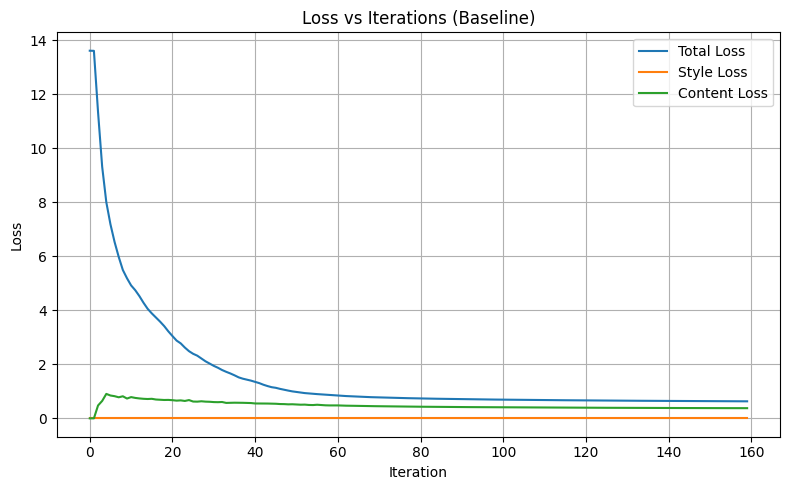

[Cell 8] Loss curves plotted successfully.
[Cell 8] Computing layer-wise style loss contributions...
[Cell 8] Total raw style loss at final iteration: 0.0000
[Cell 8] Number of style layers considered: 5
[Cell 8] Plotting layer-wise style contribution bar chart...


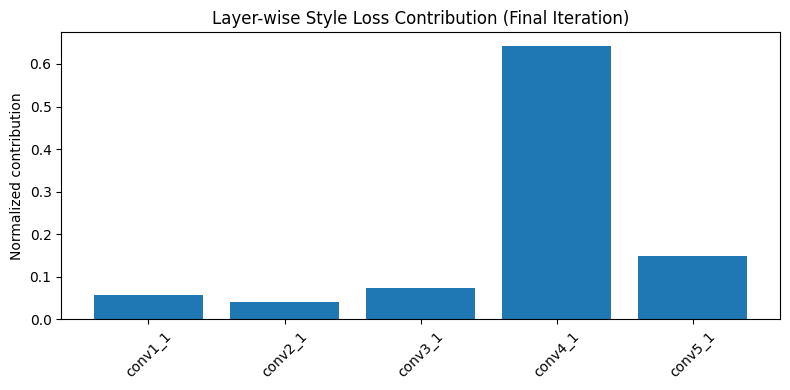

[Cell 8] Bar chart plotted successfully.
[Cell 8] Contribution table created. Preview:


,layer,raw_style_loss,normalized_contribution
0,conv1_1,1.525407e-08,0.057845
1,conv2_1,1.067228e-08,0.040471
2,conv3_1,1.934787e-08,0.073370
3,conv4_1,1.693499e-07,0.642196
4,conv5_1,3.908005e-08,0.148197


[Cell 8] Done.


In [ ]:
# Cell 8: Optimized plots – loss curves + per-layer style contribution
# Assumes `log_df` is already created in Cell 7

import matplotlib.pyplot as plt
import numpy as np

print("[Cell 8] Starting analysis...")
print(f"[Cell 8] log_df has {len(log_df)} iterations and {len(log_df.columns)} columns.")

# 1) Downsample for faster plotting (if needed)
if len(log_df) > 200:
    print("[Cell 8] Downsampling log_df to every 5th row for faster plotting...")
    log_df_plot = log_df.iloc[::5, :].reset_index(drop=True)
else:
    log_df_plot = log_df.copy()

print(f"[Cell 8] Using {len(log_df_plot)} points for plotting.")

# 2) Plot total, style, and content loss vs iteration
print("[Cell 8] Plotting loss curves...")

plt.figure(figsize=(8, 5))
plt.plot(log_df_plot["iter"], log_df_plot["total_loss"], label="Total Loss")
plt.plot(log_df_plot["iter"], log_df_plot["style_loss_total"], label="Style Loss")
plt.plot(log_df_plot["iter"], log_df_plot["content_loss_total"], label="Content Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Iterations (Baseline)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("[Cell 8] Loss curves plotted successfully.")

# 3) Compute layer-wise style contribution at final iteration
print("[Cell 8] Computing layer-wise style loss contributions...")

final_row = log_df.iloc[-1]

# Only take columns that correspond to style_* at conv layers
style_cols = [c for c in log_df.columns if c.startswith("style_conv")]
style_cols = sorted(style_cols)  # for consistent order
style_vals = [final_row[c] for c in style_cols]
style_layers = [c.replace("style_", "") for c in style_cols]

total_style_loss_raw = sum(style_vals) + 1e-8  # avoid division by zero
contrib = [v / total_style_loss_raw for v in style_vals]

print("[Cell 8] Total raw style loss at final iteration:",
      f"{total_style_loss_raw:.4f}")
print("[Cell 8] Number of style layers considered:", len(style_layers))

# 4) Bar chart of normalized contributions
print("[Cell 8] Plotting layer-wise style contribution bar chart...")

plt.figure(figsize=(8, 4))
plt.bar(style_layers, contrib)
plt.xticks(rotation=45)
plt.ylabel("Normalized contribution")
plt.title("Layer-wise Style Loss Contribution (Final Iteration)")
plt.tight_layout()
plt.show()

print("[Cell 8] Bar chart plotted successfully.")

# 5) Create a summary table (DataFrame) for later use in the paper
contrib_table = pd.DataFrame({
    "layer": style_layers,
    "raw_style_loss": style_vals,
    "normalized_contribution": contrib
})

print("[Cell 8] Contribution table created. Preview:")
display(contrib_table.head())
print("[Cell 8] Done.")


[Cell 9] Starting ablation experiments...

[Cell 9] === Running ablation: all_layers ===
[Cell 9] Using style layers: ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
[all_layers] Iter 0 | Total: 13.6073 | Style: 0.0000 | Content: 0.0000
[all_layers] Iter 50 | Total: 0.9759 | Style: 0.0000 | Content: 0.5210
[all_layers] Iter 100 | Total: 0.6913 | Style: 0.0000 | Content: 0.4073


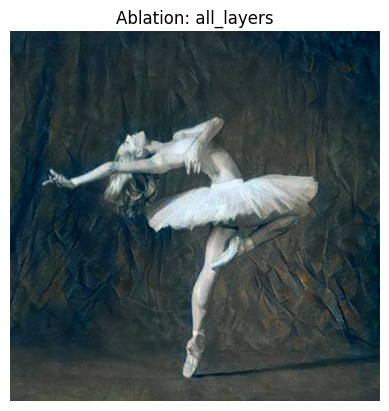

[Cell 9] Saved output image to ablation_outputs/all_layers.png

[Cell 9] === Running ablation: shallow_only ===
[Cell 9] Using style layers: ['conv1_1', 'conv2_1']
[shallow_only] Iter 0 | Total: 5.6151 | Style: 0.0000 | Content: 0.0000
[shallow_only] Iter 50 | Total: 0.1040 | Style: 0.0000 | Content: 0.0383
[shallow_only] Iter 100 | Total: 0.0456 | Style: 0.0000 | Content: 0.0181


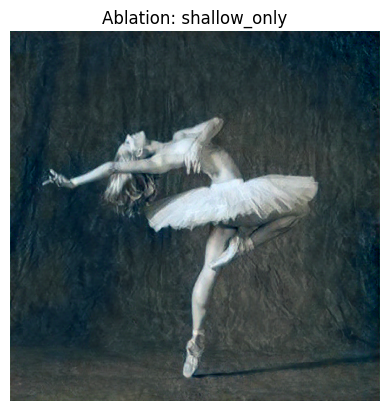

[Cell 9] Saved output image to ablation_outputs/shallow_only.png

[Cell 9] === Running ablation: mid_only ===
[Cell 9] Using style layers: ['conv3_1', 'conv4_1']
[mid_only] Iter 0 | Total: 7.8116 | Style: 0.0000 | Content: 0.0000
[mid_only] Iter 50 | Total: 0.6971 | Style: 0.0000 | Content: 0.4091
[mid_only] Iter 100 | Total: 0.5818 | Style: 0.0000 | Content: 0.3469


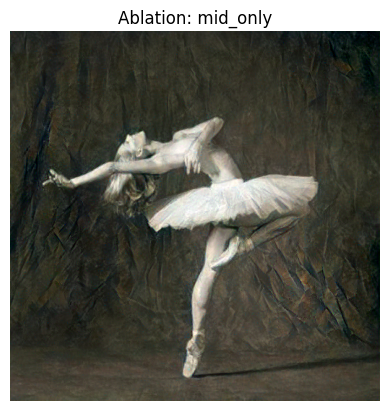

[Cell 9] Saved output image to ablation_outputs/mid_only.png

[Cell 9] === Running ablation: deep_only ===
[Cell 9] Using style layers: ['conv5_1']
[deep_only] Iter 0 | Total: 0.1807 | Style: 0.0000 | Content: 0.0000
[deep_only] Iter 50 | Total: 0.1377 | Style: 0.0000 | Content: 0.0415
[deep_only] Iter 100 | Total: 0.1303 | Style: 0.0000 | Content: 0.0449


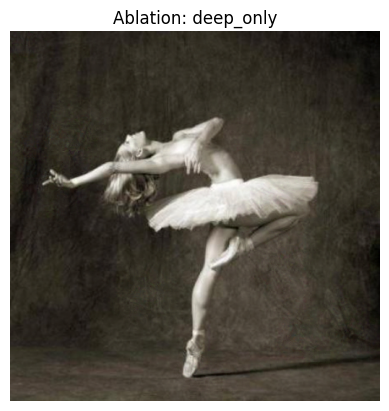

[Cell 9] Saved output image to ablation_outputs/deep_only.png

[Cell 9] === Running ablation: no_conv3_1 ===
[Cell 9] Using style layers: ['conv1_1', 'conv2_1', 'conv4_1', 'conv5_1']
[no_conv3_1] Iter 0 | Total: 7.5996 | Style: 0.0000 | Content: 0.0000
[no_conv3_1] Iter 50 | Total: 0.7741 | Style: 0.0000 | Content: 0.4145
[no_conv3_1] Iter 100 | Total: 0.6159 | Style: 0.0000 | Content: 0.3444


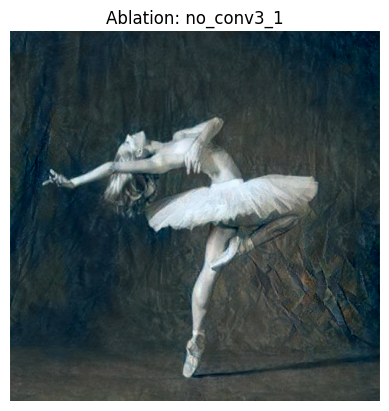

[Cell 9] Saved output image to ablation_outputs/no_conv3_1.png

[Cell 9] Ablation summary:


,config,style_layers_used,total_style_loss,final_total_loss
0,all_layers,"conv1_1, conv2_1, conv3_1, conv4_1, conv5_1",2.602291e-07,0.644424
1,shallow_only,"conv1_1, conv2_1",1.853938e-08,0.032061
2,mid_only,"conv3_1, conv4_1",2.218080e-07,0.548479
3,deep_only,conv5_1,8.020990e-08,0.126741
4,no_conv3_1,"conv1_1, conv2_1, conv4_1, conv5_1",2.540796e-07,0.582178


[Cell 9] Ablation experiments completed.


In [ ]:
# Cell 9: Ablation – different style layer configurations
print("[Cell 9] Starting ablation experiments...")

# Define different style-layer configurations to study their effects
ablation_configs = {
    "all_layers": default_style_layers,
    "shallow_only": ['conv1_1', 'conv2_1'],
    "mid_only": ['conv3_1', 'conv4_1'],
    "deep_only": ['conv5_1'],
    "no_conv3_1": [l for l in default_style_layers if l != 'conv3_1'],
}

os.makedirs("ablation_outputs", exist_ok=True)

ablation_results = []

for config_name, style_layer_list in ablation_configs.items():
    print(f"\n[Cell 9] === Running ablation: {config_name} ===")
    print(f"[Cell 9] Using style layers: {style_layer_list}")

    out_img, df_log = run_style_transfer(
        content_img,
        style_img,
        num_steps=120,                  # slightly fewer steps for speed
        style_weight=1e6,
        content_weight=1,
        style_layers=style_layer_list,
        content_layers=default_content_layers,
        log_prefix=config_name
    )

    # Show image inline (optional – can comment out if running many experiments)
    imshow(out_img, title=f"Ablation: {config_name}")

    # Save the final stylized image
    out_path = f"ablation_outputs/{config_name}.png"
    unloader(out_img.squeeze(0)).save(out_path)
    print(f"[Cell 9] Saved output image to {out_path}")

    # Record final style loss breakdown for this configuration
    final = df_log.iloc[-1]
    style_cols_cfg = [c for c in df_log.columns if c.startswith("style_conv")]
    style_vals_cfg = [final[c] for c in style_cols_cfg]
    style_layers_cfg = [c.replace("style_", "") for c in style_cols_cfg]
    total_style_loss_cfg = float(sum(style_vals_cfg))
    final_total_loss_cfg = float(final["total_loss"])

    ablation_results.append({
        "config": config_name,
        "style_layers_used": ", ".join(style_layer_list),
        "total_style_loss": total_style_loss_cfg,
        "final_total_loss": final_total_loss_cfg
    })

# Summary DataFrame
ablation_df = pd.DataFrame(ablation_results)

print("\n[Cell 9] Ablation summary:")
display(ablation_df)
print("[Cell 9] Ablation experiments completed.")


In [ ]:
# Cell 10: Advanced Content & Style metrics (including SSIM and PSNR)
print("[Cell 10] Computing advanced metrics for each ablation config...")

def get_numpy_image(tensor):
    """Helper to convert torch tensor to 0-255 uint8 numpy array for SSIM/PSNR"""
    img = tensor.cpu().clone().squeeze(0)
    img = img.detach().numpy().transpose(1, 2, 0)
    # Ensure pixels are in [0, 255] range for standard metric calculation
    img = (img * 255).clip(0, 255).astype(np.uint8)
    return img

def vgg_feature_distance(img1, img2, layers):
    norm = Normalization(normalization_mean, normalization_std).to(device)
    with torch.no_grad():
        f1 = extract_features(norm(img1), vgg, layers_to_return=set(layers))
        f2 = extract_features(norm(img2), vgg, layers_to_return=set(layers))
    d = 0.0
    for l in layers:
        d += torch.nn.functional.mse_loss(f1[l], f2[l]).item()
    return d

metrics_rows = []

# Prepare the original content image for SSIM/PSNR
content_np = get_numpy_image(content_img)

for config_name in ablation_configs.keys():
    stylized_img_path = f"ablation_outputs/{config_name}.png"

    if not os.path.exists(stylized_img_path):
        print(f"Warning: {stylized_img_path} not found. Skipping...")
        continue

    print(f"[Cell 10] Calculating SSIM/PSNR for: {config_name}")

    stylized_img = load_image(stylized_img_path)
    stylized_np = get_numpy_image(stylized_img)

    # 1. Original VGG Feature Distances
    content_dist = vgg_feature_distance(stylized_img, content_img, default_content_layers)
    style_dist = vgg_feature_distance(stylized_img, style_img, default_style_layers)

    # 2. Structural Similarity Index (SSIM) - channel_axis=-1 for RGB
    score_ssim = ssim(content_np, stylized_np, channel_axis=-1, data_range=255)

    # 3. Peak Signal-to-Noise Ratio (PSNR)
    score_psnr = psnr(content_np, stylized_np, data_range=255)

    metrics_rows.append({
        "config": config_name,
        "content_feature_distance": content_dist,
        "SSIM": score_ssim,
        "PSNR_dB": score_psnr,
        "style_feature_distance": style_dist
    })

metrics_df = pd.DataFrame(metrics_rows)

print("\n=== Table III: Content vs Style Perceptual Metrics ===")
display(metrics_df)
print("[Cell 10] Metrics computation completed.")

[Cell 10] Computing advanced metrics for each ablation config...
[Cell 10] Calculating SSIM/PSNR for: all_layers
[Cell 10] Calculating SSIM/PSNR for: shallow_only
[Cell 10] Calculating SSIM/PSNR for: mid_only
[Cell 10] Calculating SSIM/PSNR for: deep_only
[Cell 10] Calculating SSIM/PSNR for: no_conv3_1

=== Table III: Content vs Style Perceptual Metrics ===


,config,content_feature_distance,SSIM,PSNR_dB,style_feature_distance
0,all_layers,0.429920,0.761797,24.322634,15.713511
1,shallow_only,0.036610,0.794852,24.286664,13.878810
2,mid_only,0.337350,0.805795,31.364555,15.988361
3,deep_only,0.051732,0.987860,46.195750,13.817462
4,no_conv3_1,0.363323,0.780972,24.398033,15.713398


[Cell 10] Metrics computation completed.


In [ ]:
# Cell 12: Summary tables for paper – layer importance + ablation + metrics
print("[Cell 12] Preparing summary tables for paper...")

print("=== Layer-wise style contribution (baseline) ===")
try:
    display(contrib_table)
except NameError:
    print("Warning: contrib_table not found. Make sure Cell 8 ran successfully.")

print("\n=== Ablation summary (config vs losses) ===")
try:
    display(ablation_df)
except NameError:
    print("Warning: ablation_df not found. Make sure Cell 9 ran successfully.")

print("\n=== Content vs Style feature distances (ablation configs) ===")
try:
    display(metrics_df)
except NameError:
    print("Warning: metrics_df not found. Make sure Cell 10 ran successfully.")

print("\n[Cell 12] Summary tables ready for export into your paper.")


[Cell 12] Preparing summary tables for paper...
=== Layer-wise style contribution (baseline) ===


,layer,raw_style_loss,normalized_contribution
0,conv1_1,1.525407e-08,0.057845
1,conv2_1,1.067228e-08,0.040471
2,conv3_1,1.934787e-08,0.073370
3,conv4_1,1.693499e-07,0.642196
4,conv5_1,3.908005e-08,0.148197



=== Ablation summary (config vs losses) ===


,config,style_layers_used,total_style_loss,final_total_loss
0,all_layers,"conv1_1, conv2_1, conv3_1, conv4_1, conv5_1",2.602291e-07,0.644424
1,shallow_only,"conv1_1, conv2_1",1.853938e-08,0.032061
2,mid_only,"conv3_1, conv4_1",2.218080e-07,0.548479
3,deep_only,conv5_1,8.020990e-08,0.126741
4,no_conv3_1,"conv1_1, conv2_1, conv4_1, conv5_1",2.540796e-07,0.582178



=== Content vs Style feature distances (ablation configs) ===


,config,content_feature_distance,SSIM,PSNR_dB,style_feature_distance
0,all_layers,0.429920,0.761797,24.322634,15.713511
1,shallow_only,0.036610,0.794852,24.286664,13.878810
2,mid_only,0.337350,0.805795,31.364555,15.988361
3,deep_only,0.051732,0.987860,46.195750,13.817462
4,no_conv3_1,0.363323,0.780972,24.398033,15.713398



[Cell 12] Summary tables ready for export into your paper.
